In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import perf_counter

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
!gdown 1r8BvjiakPswIqnlZRYfRE47SgwYXLekB

Downloading...
From: https://drive.google.com/uc?id=1r8BvjiakPswIqnlZRYfRE47SgwYXLekB
To: /content/Flower.zip
100% 236M/236M [00:03<00:00, 65.6MB/s]


In [ ]:
!unzip Flower

In [2]:
image_dir = Path('/content/flowers')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

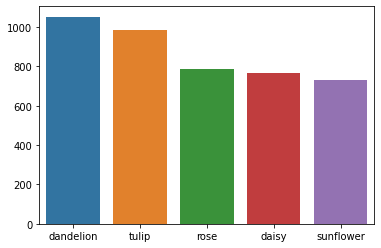

In [ ]:
sns.barplot(x=image_df.Label.value_counts().index, y=image_df.Label.value_counts().values)
plt.show()

In [8]:
train_ds, test_ds = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [9]:
train_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(train_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)
test_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)

Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


##Train my own model

In [ ]:
def my_model(summary=False):
  input = layers.Input(shape=(224,224,3))

  x = layers.Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu')(input)
  x = layers.Conv2D(32, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  output = layers.Dense(5, activation='softmax')(x)

  model = Model(input, output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(model.summary())
    
  return model

In [ ]:
model_own = my_model(summary=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_65 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 110, 110, 32)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 110, 110, 32)      0         
                                                                 
 conv2d_66 (Conv2D)          (None, 110, 110, 64)      18496     
                                                           

In [ ]:
start_tra = perf_counter()
history = model_own.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 25s 217ms/step - loss: 2.2147 - accuracy: 0.3145 - val_loss: 2.3817 - val_accuracy: 0.3623
Epoch 2/20
108/108 [==============================] - 23s 213ms/step - loss: 1.6949 - accuracy: 0.3510 - val_loss: 3.3407 - val_accuracy: 0.3900
Epoch 3/20
108/108 [==============================] - 23s 209ms/step - loss: 1.6561 - accuracy: 0.3469 - val_loss: 1.5701 - val_accuracy: 0.3356
Epoch 4/20
108/108 [==============================] - 25s 227ms/step - loss: 1.5500 - accuracy: 0.3516 - val_loss: 1.4731 - val_accuracy: 0.3044
Epoch 5/20
108/108 [==============================] - 23s 215ms/step - loss: 1.5226 - accuracy: 0.3637 - val_loss: 1.2772 - val_accuracy: 0.4039
Epoch 6/20
108/108 [==============================] - 23s 210ms/step - loss: 1.4696 - accuracy: 0.3872 - val_loss: 1.5798 - val_accuracy: 0.2824
Epoch 7/20
108/108 [==============================] - 23s 212ms/step - loss: 1.3926 - accuracy: 0.4075 - val_loss: 1.3442 - val_ac

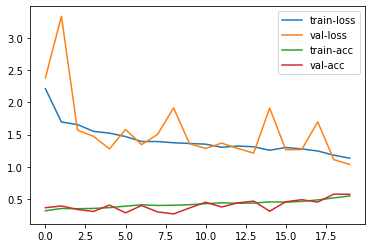

In [ ]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.plot(history.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_own = model_own.evaluate(test_ds)[1]

27/27 [==============================] - 3s 109ms/step - loss: 1.0354 - accuracy: 0.5718


## TransferLearning Part 1 (Just change the last Dense layer--->to change the number of classes)

Notice that we can not use: vgg_model = VGG16(weights='imagenet',input_shape=(224,224,3), include_top=True, classes=10) because the model just accept imagenet weights when we don't change the number of its classes(1000); otherwise we should train the model on our dataset without imagenet weights and just use VGG's architecture (which is not useful beacuse of the time and low amount of data)

In [ ]:
# lest's first look at the complete VGG16 architecture
vgg_test = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)
vgg_test.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
def VGG16_1(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in vgg_model.layers[:]:
      layer.trainable = False
  # this part is just like:
  # vgg_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = vgg_model.get_layer('fc2').output # this part is just like: output = vgg_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_1 = VGG16_1(summary=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_1 = vgg_1.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 28s 232ms/step - loss: 1.2214 - accuracy: 0.5407 - val_loss: 0.9234 - val_accuracy: 0.6539
Epoch 2/20
108/108 [==============================] - 24s 218ms/step - loss: 0.8550 - accuracy: 0.6901 - val_loss: 0.8171 - val_accuracy: 0.7338
Epoch 3/20
108/108 [==============================] - 23s 209ms/step - loss: 0.7797 - accuracy: 0.7179 - val_loss: 0.7480 - val_accuracy: 0.7211
Epoch 4/20
108/108 [==============================] - 22s 207ms/step - loss: 0.7148 - accuracy: 0.7428 - val_loss: 0.7409 - val_accuracy: 0.7292
Epoch 5/20
108/108 [==============================] - 23s 211ms/step - loss: 0.6803 - accuracy: 0.7544 - val_loss: 0.6622 - val_accuracy: 0.7697
Epoch 6/20
108/108 [==============================] - 23s 211ms/step - loss: 0.6773 - accuracy: 0.7547 - val_loss: 0.7155 - val_accuracy: 0.7361
Epoch 7/20
108/108 [==============================] - 23s 215ms/step - loss: 0.6131 - accuracy: 0.7851 - val_loss: 0.6426 - val_ac

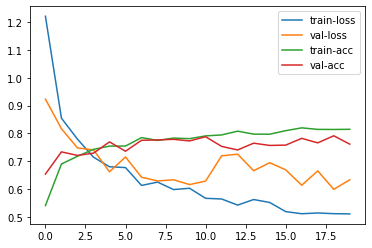

In [ ]:
plt.plot(history_1.history['loss'], label='train-loss')
plt.plot(history_1.history['val_loss'], label='val-loss')
plt.plot(history_1.history['accuracy'], label='train-acc')
plt.plot(history_1.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg1 = vgg_1.evaluate(test_ds)[1]

27/27 [==============================] - 5s 168ms/step - loss: 0.6335 - accuracy: 0.7616


## TransferLearning Part 2 (Change the last Layer and add some dense/dropout layers too)

In [ ]:
def VGG16_2(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in vgg_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = vgg_model.get_layer('fc2').output # this part is just like: output = vgg_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_2 = VGG16_2(summary=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_2 = vgg_2.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 24s 213ms/step - loss: 1.8685 - accuracy: 0.4599 - val_loss: 0.8820 - val_accuracy: 0.6574
Epoch 2/20
108/108 [==============================] - 24s 219ms/step - loss: 0.9299 - accuracy: 0.6455 - val_loss: 1.0299 - val_accuracy: 0.6192
Epoch 3/20
108/108 [==============================] - 23s 210ms/step - loss: 0.8288 - accuracy: 0.6869 - val_loss: 0.7778 - val_accuracy: 0.7118
Epoch 4/20
108/108 [==============================] - 23s 209ms/step - loss: 0.7385 - accuracy: 0.7217 - val_loss: 0.7735 - val_accuracy: 0.7164
Epoch 5/20
108/108 [==============================] - 23s 211ms/step - loss: 0.7287 - accuracy: 0.7220 - val_loss: 0.7069 - val_accuracy: 0.7616
Epoch 6/20
108/108 [==============================] - 23s 212ms/step - loss: 0.7264 - accuracy: 0.7298 - val_loss: 0.8574 - val_accuracy: 0.6759
Epoch 7/20
108/108 [==============================] - 23s 212ms/step - loss: 0.6682 - accuracy: 0.7550 - val_loss: 0.6476 - val_ac

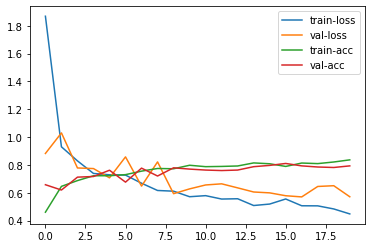

In [ ]:
plt.plot(history_2.history['loss'], label='train-loss')
plt.plot(history_2.history['val_loss'], label='val-loss')
plt.plot(history_2.history['accuracy'], label='train-acc')
plt.plot(history_2.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg2 = vgg_2.evaluate(test_ds)[1]

27/27 [==============================] - 5s 163ms/step - loss: 0.5708 - accuracy: 0.7928


## TransferLearning Part 3 (Open the last trainable layers and add some dense/dropout layers)

In [ ]:
def VGG16_3(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)

  for layer in vgg_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  # let the layers after last block anf fully connected layers be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv1':
      set_trainable=True
    lyr.trainable = set_trainable

  # last fully connected layer before Dense(1000) in image net
  output = vgg_model.get_layer('fc2').output # this part is just like: output = vgg_model.layers[-2].output
  output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)
  vgg_model = Model(vgg_model.input, output)

  # vgg_model.get_layer('block5_conv3').trainable = True
  # vgg_model.get_layer('fc1').trainable = True
  # vgg_model.get_layer('fc2').trainable = True
  # vgg_model.get_layer('first_new_fc').trainable = True

  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_3 = VGG16_3(summary=True)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_3 = vgg_3.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 30s 266ms/step - loss: 4.0336 - accuracy: 0.2467 - val_loss: 1.5461 - val_accuracy: 0.2928
Epoch 2/20
108/108 [==============================] - 28s 259ms/step - loss: 1.4368 - accuracy: 0.3652 - val_loss: 1.2855 - val_accuracy: 0.3681
Epoch 3/20
108/108 [==============================] - 27s 253ms/step - loss: 1.1390 - accuracy: 0.4697 - val_loss: 1.1752 - val_accuracy: 0.5093
Epoch 4/20
108/108 [==============================] - 28s 256ms/step - loss: 1.0770 - accuracy: 0.5178 - val_loss: 1.1099 - val_accuracy: 0.6007
Epoch 5/20
108/108 [==============================] - 28s 257ms/step - loss: 0.9494 - accuracy: 0.5931 - val_loss: 0.8378 - val_accuracy: 0.6285
Epoch 6/20
108/108 [==============================] - 28s 255ms/step - loss: 0.7919 - accuracy: 0.6887 - val_loss: 0.7945 - val_accuracy: 0.6609
Epoch 7/20
108/108 [==============================] - 28s 255ms/step - loss: 0.7069 - accuracy: 0.7182 - val_loss: 0.6771 - val_ac

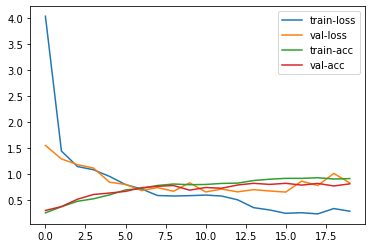

In [ ]:
plt.plot(history_3.history['loss'], label='train-loss')
plt.plot(history_3.history['val_loss'], label='val-loss')
plt.plot(history_3.history['accuracy'], label='train-acc')
plt.plot(history_3.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg3 = vgg_3.evaluate(test_ds)[1]

27/27 [==============================] - 5s 167ms/step - loss: 0.8235 - accuracy: 0.8056


## TransterLearning Part 4 (Change Fully Connected Layers) 

In [ ]:
# lest's first look at the VGG16 architecture without fully Connected 
vgg_test = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
vgg_test.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def VGG16_4(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in vgg_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  output = vgg_model.get_layer('block5_pool').output # this part is just like vgg_model.layers[-1].output)
  output = layers.Flatten(name='flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_4 = VGG16_4(summary=True)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_4 = vgg_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 24s 213ms/step - loss: 1.6280 - accuracy: 0.6241 - val_loss: 0.5828 - val_accuracy: 0.7917
Epoch 2/20
108/108 [==============================] - 24s 221ms/step - loss: 0.4412 - accuracy: 0.8375 - val_loss: 0.6954 - val_accuracy: 0.7650
Epoch 3/20
108/108 [==============================] - 23s 213ms/step - loss: 0.2402 - accuracy: 0.9192 - val_loss: 0.7970 - val_accuracy: 0.7720
Epoch 4/20
108/108 [==============================] - 23s 210ms/step - loss: 0.1819 - accuracy: 0.9285 - val_loss: 0.7100 - val_accuracy: 0.7847
Epoch 5/20
108/108 [==============================] - 23s 213ms/step - loss: 0.1122 - accuracy: 0.9580 - val_loss: 0.9172 - val_accuracy: 0.7697
Epoch 6/20
108/108 [==============================] - 24s 217ms/step - loss: 0.1116 - accuracy: 0.9624 - val_loss: 0.7753 - val_accuracy: 0.8056
Epoch 7/20
108/108 [==============================] - 23s 212ms/step - loss: 0.0784 - accuracy: 0.9760 - val_loss: 0.7967 - val_ac

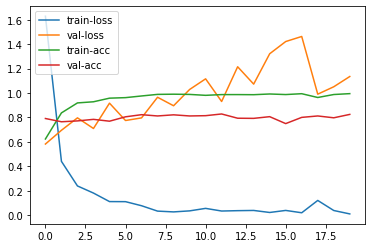

In [ ]:
plt.plot(history_4.history['loss'], label='train-loss')
plt.plot(history_4.history['val_loss'], label='val-loss')
plt.plot(history_4.history['accuracy'], label='train-acc')
plt.plot(history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg4 = vgg_4.evaluate(test_ds)[1]

27/27 [==============================] - 5s 165ms/step - loss: 1.1351 - accuracy: 0.8252


In [ ]:
def anotherVGG16_4(summary=False):

  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
  vgg_model.trainable = False

  inputs = layers.Input(shape=(224,224,3))
  x = vgg_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
another_vgg_4 = anotherVGG16_4(summary=True)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_22 (Dense)            (None, 1024)              525312    
                                                                 
 dense_23 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_39 (Dropout)        (None, 1024)              0         
                                                          

In [ ]:
start_tra = perf_counter()
another_history_4 = another_vgg_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 24s 212ms/step - loss: 0.9819 - accuracy: 0.6258 - val_loss: 0.7391 - val_accuracy: 0.7280
Epoch 2/20
108/108 [==============================] - 22s 207ms/step - loss: 0.6027 - accuracy: 0.7840 - val_loss: 0.5814 - val_accuracy: 0.8009
Epoch 3/20
108/108 [==============================] - 23s 208ms/step - loss: 0.5126 - accuracy: 0.8083 - val_loss: 0.5799 - val_accuracy: 0.7940
Epoch 4/20
108/108 [==============================] - 22s 206ms/step - loss: 0.4537 - accuracy: 0.8352 - val_loss: 0.5845 - val_accuracy: 0.7951
Epoch 5/20
108/108 [==============================] - 23s 208ms/step - loss: 0.3929 - accuracy: 0.8517 - val_loss: 0.4890 - val_accuracy: 0.8310
Epoch 6/20
108/108 [==============================] - 22s 207ms/step - loss: 0.3408 - accuracy: 0.8714 - val_loss: 0.6869 - val_accuracy: 0.7812
Epoch 7/20
108/108 [==============================] - 22s 208ms/step - loss: 0.3010 - accuracy: 0.8902 - val_loss: 0.4772 - val_ac

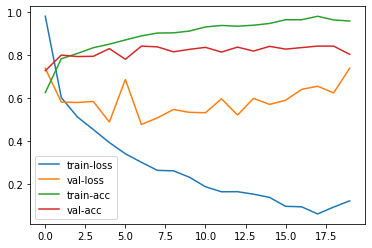

In [ ]:
plt.plot(another_history_4.history['loss'], label='train-loss')
plt.plot(another_history_4.history['val_loss'], label='val-loss')
plt.plot(another_history_4.history['accuracy'], label='train-acc')
plt.plot(another_history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
another_score_vgg4 = another_vgg_4.evaluate(test_ds)[1]

27/27 [==============================] - 5s 163ms/step - loss: 0.7398 - accuracy: 0.8044


## TransferLearinig Part 5 (Open the last trainable layers before fully connected and add some dense/dropout layers)

In [5]:
def VGG16_5(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in vgg_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv3':
      set_trainable=True
    lyr.trainable = set_trainable

  output = vgg_model.get_layer('block5_pool').output # this part is just like vgg_model.layers[-1].output
  output = layers.Flatten(name='flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc3')(output)
  output = layers.Dropout(0.4)(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [6]:
vgg_5 = VGG16_5(summary=True)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
start_tra = perf_counter()
history_5 = vgg_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 36s 225ms/step - loss: 1.1957 - accuracy: 0.6571 - val_loss: 0.6129 - val_accuracy: 0.7859
Epoch 2/20
108/108 [==============================] - 22s 207ms/step - loss: 0.4853 - accuracy: 0.8326 - val_loss: 0.6766 - val_accuracy: 0.7812
Epoch 3/20
108/108 [==============================] - 22s 203ms/step - loss: 0.3328 - accuracy: 0.8879 - val_loss: 0.5039 - val_accuracy: 0.8183
Epoch 4/20
108/108 [==============================] - 22s 203ms/step - loss: 0.2504 - accuracy: 0.9172 - val_loss: 0.5537 - val_accuracy: 0.8056
Epoch 5/20
108/108 [==============================] - 22s 206ms/step - loss: 0.2041 - accuracy: 0.9398 - val_loss: 0.6394 - val_accuracy: 0.8067
Epoch 6/20
108/108 [==============================] - 23s 208ms/step - loss: 0.1288 - accuracy: 0.9612 - val_loss: 0.8006 - val_accuracy: 0.8449
Epoch 7/20
108/108 [==============================] - 23s 211ms/step - loss: 0.1598 - accuracy: 0.9513 - val_loss: 0.6696 - val_ac

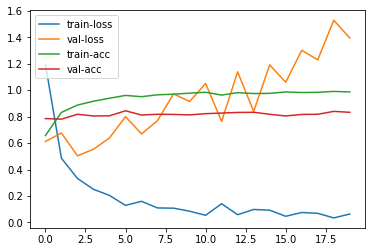

In [11]:
plt.plot(history_5.history['loss'], label='train-loss')
plt.plot(history_5.history['val_loss'], label='val-loss')
plt.plot(history_5.history['accuracy'], label='train-acc')
plt.plot(history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [12]:
score_vgg5 = vgg_5.evaluate(test_ds)[1]

27/27 [==============================] - 5s 164ms/step - loss: 1.3960 - accuracy: 0.8333


In [13]:
def anotherVGG16_5(summary=False):

  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
  vgg_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv3':
      set_trainable=True
    lyr.trainable = set_trainable

  inputs = layers.Input(shape=(224,224,3))
  x = vgg_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [14]:
another_vgg_5 = anotherVGG16_5(summary=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_3 (Dense)             (None, 1024)              1049600   
                                                           

In [15]:
start_tra = perf_counter()
another_history_5 = another_vgg_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 25s 222ms/step - loss: 1.5940 - accuracy: 0.3015 - val_loss: 1.3844 - val_accuracy: 0.4676
Epoch 2/20
108/108 [==============================] - 22s 205ms/step - loss: 1.3742 - accuracy: 0.4382 - val_loss: 1.2210 - val_accuracy: 0.5914
Epoch 3/20
108/108 [==============================] - 22s 206ms/step - loss: 1.2138 - accuracy: 0.5476 - val_loss: 1.0947 - val_accuracy: 0.6377
Epoch 4/20
108/108 [==============================] - 22s 208ms/step - loss: 1.0982 - accuracy: 0.5940 - val_loss: 0.9993 - val_accuracy: 0.6562
Epoch 5/20
108/108 [==============================] - 22s 208ms/step - loss: 1.0157 - accuracy: 0.6253 - val_loss: 0.9346 - val_accuracy: 0.6991
Epoch 6/20
108/108 [==============================] - 23s 209ms/step - loss: 0.9473 - accuracy: 0.6444 - val_loss: 0.8789 - val_accuracy: 0.7199
Epoch 7/20
108/108 [==============================] - 22s 207ms/step - loss: 0.8818 - accuracy: 0.6881 - val_loss: 0.8349 - val_ac

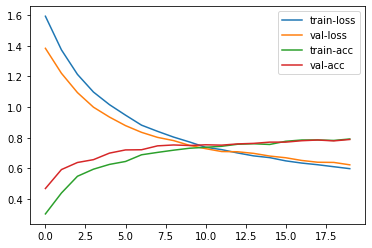

In [16]:
plt.plot(another_history_5.history['loss'], label='train-loss')
plt.plot(another_history_5.history['val_loss'], label='val-loss')
plt.plot(another_history_5.history['accuracy'], label='train-acc')
plt.plot(another_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [17]:
another_score_vgg5 = another_vgg_5.evaluate(test_ds)[1]

27/27 [==============================] - 4s 159ms/step - loss: 0.6225 - accuracy: 0.7882


In [ ]:
prediction = another_vgg_5.predict(test_ds)
prediction = np.argmax(prediction, axis=1)

FeatuteExtraction

In [9]:
model = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(224, 224, 3))
model.summary()
# model.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
datagenerator = ImageDataGenerator(rescale=1./255)

def feature_extractor(sample_size, batch_size, data_frame):
  features = np.zeros((sample_size, 7, 7, 512))
  labels = np.zeros((sample_size,5))
  datagen = datagenerator.flow_from_dataframe(data_frame,
                                            x_col='Filepath',
                                            y_col='Label',
                                            target_size=(224, 224),
                                            color_mode='rgb',
                                            class_mode='categorical',
                                            batch_size=32)
  cnt = 0 
  for input_pxl, lbl in datagen:
    features_batch = model.predict(input_pxl)
    features[cnt * batch_size : (cnt+1) * batch_size] = features_batch
    labels[cnt * batch_size : (cnt+1) * batch_size] = lbl
    cnt += 1
    if cnt * batch_size > sample_size:
      break
    

  return features, labels

In [11]:
train_ds, test_ds = train_test_split(image_df, test_size=0.1, random_state=1)

In [12]:
train_features, train_labels = feature_extractor(len(train_ds), batch_size=32, data_frame=train_ds)
test_features, test_labels = feature_extractor(len(test_ds), batch_size=32, data_frame=test_ds)

Found 3885 validated image filenames belonging to 5 classes.
1/1 [==============================] - 2s 2s/step
Found 432 validated image filenames belonging to 5 classes.
1/1 [==============================] - 2s 2s/step


*First train a neural network with these features*

In [13]:
train_features = train_features.reshape(-1, 7*7*512)
test_features = test_features.reshape(-1, 7*7*512)

n_features = (train_features.shape[1])
input = layers.Input(shape=n_features)

layer1 = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(input)
layer2 = layers.BatchNormalization()(layer1)
layer3 = layers.Dropout(0.5)(layer2)

output = layers.Dense(5, activation='softmax')(layer3)

model = Model(input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(train_features, train_labels,epochs=20 ,batch_size=64, validation_data=(test_features, test_labels))

Epoch 1/20
61/61 [==============================] - 2s 12ms/step - loss: 0.8698 - accuracy: 0.7184 - val_loss: 1.2642 - val_accuracy: 0.6921
Epoch 2/20
61/61 [==============================] - 1s 9ms/step - loss: 0.3244 - accuracy: 0.8901 - val_loss: 0.6824 - val_accuracy: 0.7708
Epoch 3/20
61/61 [==============================] - 1s 8ms/step - loss: 0.1947 - accuracy: 0.9318 - val_loss: 0.5881 - val_accuracy: 0.8009
Epoch 4/20
61/61 [==============================] - 1s 8ms/step - loss: 0.0976 - accuracy: 0.9732 - val_loss: 0.6537 - val_accuracy: 0.8079
Epoch 5/20
61/61 [==============================] - 0s 8ms/step - loss: 0.0655 - accuracy: 0.9846 - val_loss: 0.6075 - val_accuracy: 0.8102
Epoch 6/20
61/61 [==============================] - 1s 9ms/step - loss: 0.0418 - accuracy: 0.9894 - val_loss: 0.5858 - val_accuracy: 0.8403
Epoch 7/20
61/61 [==============================] - 1s 9ms/step - loss: 0.0352 - accuracy: 0.9938 - val_loss: 0.7608 - val_accuracy: 0.7917
Epoch 8/20
61/61 [=

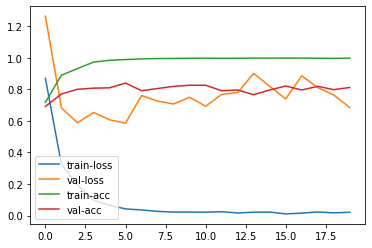

In [16]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.plot(history.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'], label='val-acc')
plt.legend()

*Now we train a svm model with extracted features*

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
clsfier = SVC(C=1, kernel='rbf')
clsfier.fit(train_features, np.argmax(train_labels, axis=1))
prediction = clsfier.predict(test_features)
print(classification_report(np.argmax(test_labels, axis=1), prediction))

              precision    recall  f1-score   support

           0       0.96      0.79      0.86        81
           1       0.75      0.90      0.82        92
           2       0.80      0.87      0.84        76
           3       0.80      0.71      0.75        79
           4       0.84      0.84      0.84       104

    accuracy                           0.82       432
   macro avg       0.83      0.82      0.82       432
weighted avg       0.83      0.82      0.82       432

